# Assignment — Compartmental Epidemic Models

In [40]:
from zlib import adler32
import matplotlib.pyplot as plt
import numpy as np

In [41]:
from scipy.optimize import minimize
import math

### Task 1. Euler method for ODE (1.0 points)

Euler method is a simple numerical procedure for solving ordinary differential equations (ODEs) with a given initial values.  For example, if we want to solve an equation

$$dx/dt = \sin(x)$$

with initial value $x = x_0$, we can subtitute $dx = \Delta x = x_{i+1} - x_{i}$ and $dt = \Delta t$, therefore we obtain

$$\frac{x_{i+1} - x_i}{\Delta t} = \sin(x)$$ 
$$x_{i+1} = x_i + \sin(x)\Delta t$$

Let $\Delta t = 0.1$, and then we can solve the equation using this iterative form as follows

In [42]:
def solve_sinx(x0, dt, k):
    x = x0
    solution = [x0]
    for _ in range(k):
        dx = np.sin(x) * dt
        x = x + dx
        solution.append(x)
    return solution

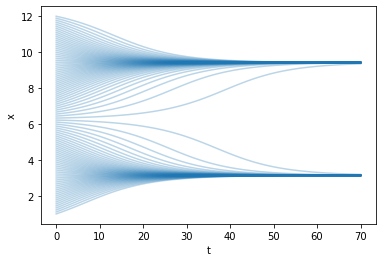

In [43]:
dt = 0.1
for x0 in np.linspace(1, 12, 100):
    solution = solve_sinx(x0, dt, 70)
    plt.plot(solution, c='tab:blue', alpha=0.3);
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Assume that we want to solve the famous chaotic Lorenz System:

$$
\begin{cases}
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z) - y\\
\frac{dz}{dt} = xy - \beta z\\
\end{cases}
$$

with parameters $\rho = 28$, $\sigma = 10$, $\beta = 8/3$ and initial values $x = y = z = 10$.

Write a function `lorenz` that takes initial values, parameters, time increment `dt`, number of iterations `k` and returns np.array with solution of the form `[[x0, y0, z0], [x1, y1, z1], ...]` so that number of rows is `k+1`.

In [44]:
def lorenz(x0, y0, z0, rho, sigma, beta, dt, k):
    xs = [x0]
    ys = [y0]
    zs = [z0]
    for i in range(k):
      dx = sigma * (ys[-1] - xs[-1]) * dt
      dy = (xs[-1] * (rho - zs[-1]) - ys[-1]) * dt
      dz = (xs[-1] * ys[-1] - beta * zs[-1]) * dt

      xs.append(xs[-1] + dx)
      ys.append(ys[-1] + dy)
      zs.append(zs[-1] + dz)
    return np.array(list(zip(xs, ys, zs)))

In [45]:
sim = lorenz(10., 10., 10., 28., 10., 8/3, 0.01, 8000-1)
assert sim.shape == (8000, 3)
assert np.all(sim[0] == [10, 10, 10])
assert np.all(sim[1].round(2) == [10., 11.7, 10.73])
assert np.all(sim[2].round(2) == [10.17, 13.31, 11.62])
assert adler32(str(sim[3].round(2)[0]).encode()) == 48496892

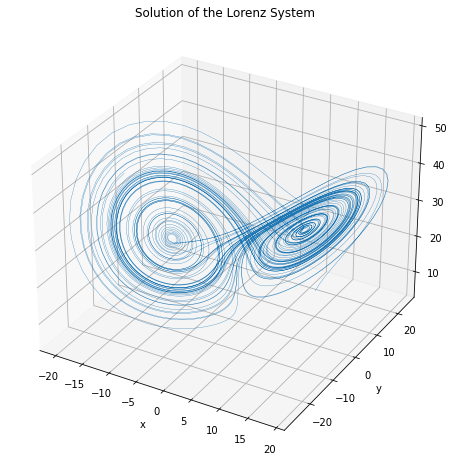

In [46]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
xs, ys, zs = sim[:, 0], sim[:, 1], sim[:, 2]
ax.plot(xs, ys, zs, lw=0.3)
plt.title('Solution of the Lorenz System')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Task 2. SI model (1.0 points)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta \frac{S}{N}I}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [47]:
def si_epidemic(total, I0, beta, dt, k):
    infectious = [I0]
    susceptible = [total - I0]

    for i in range(k):
      di = beta * susceptible[-1] / total * infectious[-1] * dt
      infectious.append(infectious[-1] + di)
      susceptible.append(total - infectious[-1])
    return np.array(list(zip(susceptible, infectious)))

In [48]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

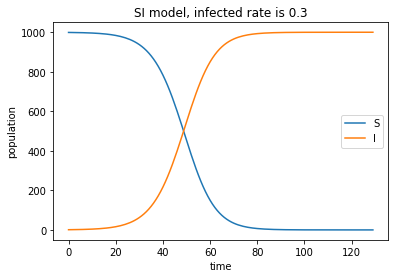

In [49]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

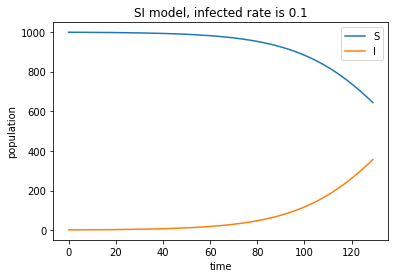

In [50]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 3. Numerical vs analytical solution of SI model (1.5 points)

The SI model has an analytical solution

$$i(t) = \frac{i_0}{i_0 + (1 - i_0)e^{-\beta t}}$$

where $i(t)$ is the share of infected people at time moment $t$. Let us compare the analytical solution and Euler method.

Write a function `si_epidemic_analytically` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns np.array `[[S0, I0], [S1, I1], ...]` is an analytical solution so that number of rows is `k+1`.

In [51]:
def si_epidemic_analytically(total, I0, beta, dt, k):
    infectious = [I0]
    susceptible = [total - I0]
    i0 = I0 / total

    for i in range(k):
      infectious.append(
          (i0 / (i0 + (1 - i0) * np.exp(-beta * dt * (i + 1)))) * total
      )
      susceptible.append(total - infectious[-1])
    return np.array(list(zip(susceptible, infectious)))

In [52]:
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert analytical_solution.shape == (130, 2)
assert np.all(analytical_solution[0] == [999, 1])
assert np.all(analytical_solution[10].round(2) == [995.53, 4.47])
assert np.all(analytical_solution[-1].round(2) == [0, 1000])
assert adler32(str(analytical_solution[100].round(2)[0]).encode()) == 31785155

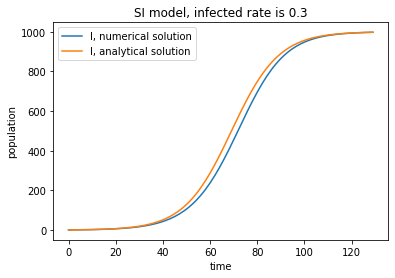

In [53]:
solution = si_epidemic(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
plt.plot(solution[:, 1], label='I, numerical solution')
plt.plot(analytical_solution[:, 1], label='I, analytical solution')
plt.legend()
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 4. SIS model (1.5 points)

Next, consider SIS model. S — susceptible, I — infectious. At the next time moment, some susceptible people become infected with infection rate $\beta$ and some infected people become susceptible with recovery rate $\gamma$. The model is defined as follows:

Dynamic form

$$S \underset{\beta S I}{\to} I \underset{\gamma I}{\to} S$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I - \gamma I$$

$$S + I = N$$

where $N$ is the total population. 

Write a function `sis_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, recovery rate `gamma`, time increment `dt`, number of iterations `k` and returns a solution of the form of a np.array

`[[S0, I0], [S1, I1], ...]`

so that number of rows is `k+1`.

In [54]:
def sis_epidemic(total, I0, beta, gamma, dt, k):
    # YOUR CODE HERE
    result = [[total - I0, I0]]
    for i in range(k):
      S = result[-1][0]
      I = result[-1][1]
      new_i = I + ((beta * (S/total) * I) - (gamma * I)) * dt
      new_s = total - new_i
      result.append([new_s, new_i])
    return np.asarray(result)

In [55]:
total = 1000
beta, gamma = 0.3, 0.1
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=600-1)
assert solution.shape == (600, 2)
assert np.all(solution[0] == [900, 100])
assert np.all(solution[10].round(2) == [861.63, 138.37])
assert solution[-1, 1].round(2) == round((1 - gamma / beta) * total, 2)
assert adler32(str(solution[100].round(2)[0]).encode()) == 72548667

Here is the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $i(+\infty) \to (1 - \gamma / \beta)$
* If $R_0 < 1$: Disease-free State, $i(+\infty) \to 0$

where $i(t)$ is the share of infected people at the time moment $t$.

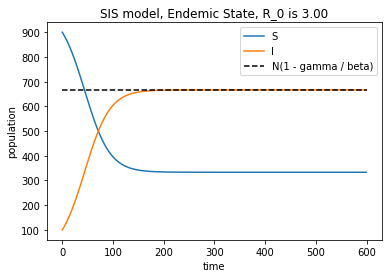

In [56]:
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.plot([0, 600], [limit, limit], '--', c='black')
plt.legend(['S', 'I', 'N(1 - gamma / beta)'])
plt.title('SIS model, Endemic State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

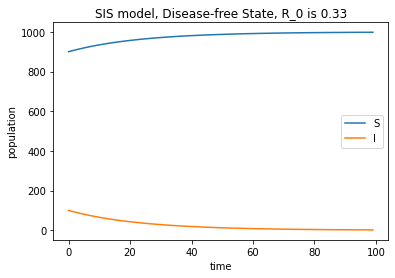

In [57]:
beta, gamma = 0.1, 0.3
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=100-1)
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.legend(['S', 'I'])
plt.title('SIS model, Disease-free State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 5. SIR model (1.5 points)

The next model is SIR. S — susceptible, I — infectious, R — recovered people. Initialy we only have a few infected persons and others are susceptible. Then some susceptible people become infected with infection rate $\beta$ and some infected people recover with recovery rate $\gamma$. There is no chance to infect after recovering. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R$$

Equation form (in proportions of the population)

$$\begin{cases}
ds/dt = -\beta si\\
di/dt = \beta si - \gamma i\\
dr/dt = \gamma i\\
s+i+r = 1
\end{cases}$$

Write a function `sir_epidemic` that takes an initial proportion `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [58]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    # YOUR CODE HERE
    res = [[s0, i0, r0]]
    s = s0
    i = i0
    r = r0
    for _ in range(k):
      s_new = s - (beta * s * i) * dt
      i_new = i + (beta * s * i - gamma * i) * dt
      r_new = r + (gamma * i) * dt
      res.append([s_new, i_new, r_new])
      s = s_new
      i = i_new
      r = r_new

    return np.array(res)

In [59]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Here is also the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $r(+\infty) \to 1$
* If $R_0 < 1$: Disease-free State, $r(+\infty) \to \text{const}$

where $r(t)$ is the share of recovered people at the time moment $t$.

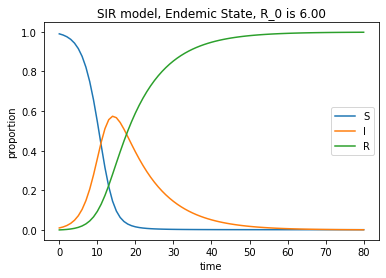

In [60]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

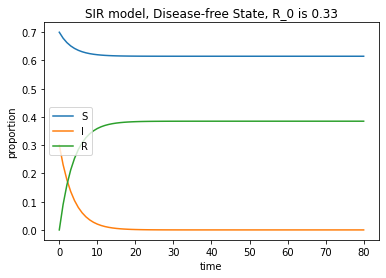

In [61]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

### Task 6. SIRS model (1.5 points)

The next model is SIRS, that is the same as SIR with an exception that recovered people lose their immunity with rate $\delta$. The dynamic form is

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R \underset{\delta R}{\to} S$$

Try to find an equation form using a dynamic form and implement this model.

Write a function `sirs_epidemic` that takes an initial proportion of `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, loss of immunity rate `delta`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [62]:
def sirs_epidemic(s0, i0, r0, beta, gamma, delta, k, dt):
    # YOUR CODE HERE
    res = [[s0, i0, r0]]
    s = s0
    i = i0
    r = r0
    for _ in range(k):
      s_new = s + ((delta * r) - beta * s * i) * dt
      i_new = i + (beta * s * i - gamma * i) * dt
      r_new = r + (gamma * i - (delta * r)) * dt
      res.append([s_new, i_new, r_new])
      s = s_new
      i = i_new
      r = r_new

    return np.array(res)

In [63]:
s0, i0, r0 = 0.9, 0.1, 0
beta, gamma, delta = 0.7, 0.3, 0.03
dt = 1
epidemic = sirs_epidemic(s0, i0, r0, beta, gamma, delta, 200, dt)
assert epidemic.shape == (201, 3)
assert np.all(epidemic[0] == [0.9, 0.1, 0])
assert np.all(epidemic[5].round(2) == [0.48, 0.27, 0.25])
assert np.all(epidemic[80].round(2) == [0.39, 0.05, 0.56])
assert np.all(epidemic[200].round(2) == [0.43, 0.05, 0.52])
assert adler32(str(epidemic[10].round(2).max()).encode()) == 32506060

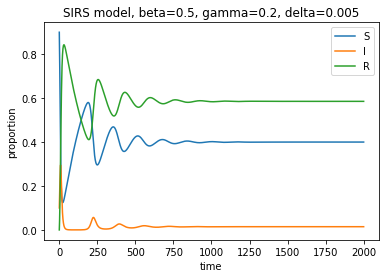

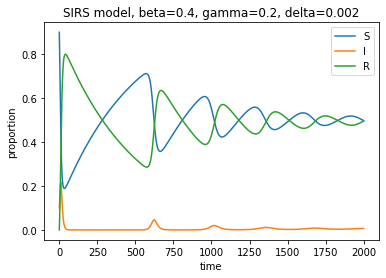

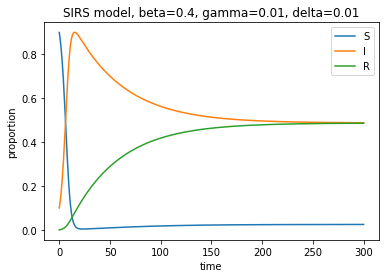

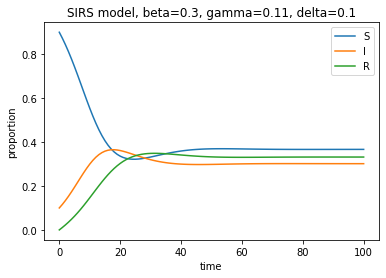

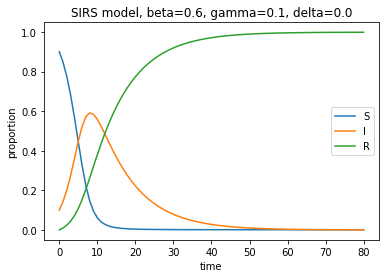

In [64]:
cases = [[0.5, 0.20, 0.005, 2000],
         [0.4, 0.20, 0.002, 2000],
         [0.4, 0.01, 0.010, 300 ],
         [0.3, 0.11, 0.100, 100 ],
         [0.6, 0.10, 0.000, 80  ]]
for beta, gamma, delta, k in cases:
    epidemic = sirs_epidemic(s0, i0, r0, beta, gamma, delta, k, dt)
    plt.plot(epidemic)
    plt.legend(['S', 'I', 'R'])
    plt.xlabel('time')
    plt.ylabel('proportion')
    plt.title('SIRS model, beta={}, gamma={}, delta={}'.format(beta, gamma, delta, k))
    plt.show()

### Task 7. Fitting SIR model (2.0 points)

Let us numerically estimate parameters of SIR model. In the current task we will define two functions: `sir_error` and `fit_sir`. The first one estimates the RMSE error between real data and SIR model. The second one minimizes the error and returns the best parameters `beta` and `gamma` for SIR model.

Write a function `sir_error` that takes SIR parameters `(beta, gamma)` and the data of the form `[[s0, i0, r0], [s1, i1, r1], ...]`. It returns RMSE error between I in the data and I from the model. Initial values of SIR are first values in the data.

In [114]:
def sir_error(params, dt, data):
    # YOUR CODE HERE
    
    result = sir_epidemic(s0, i0, r0, beta, gamma, len(data), dt)
    predicted_I = []

    for i in range(len(result)-1):

      predicted_I.append(result[i+1][1] - result[i][1])
      
    predicted_I = np.expand_dims(predicted_I, axis=-1) 
    RMSE = np.sqrt(np.sum((data - predicted_I) ** 2))
    return RMSE
    

In [115]:
from scipy.optimize import minimize

Write a function `fit_sir` that takes dt and the data of the form `[[s0, i0, r0], [s1, i1, r2], ...]`. It fits parameters minimizing `sir_error` and returns the best beta and gamma. You can use any available numerical optmizers such as L-BFGS-B in `scipy.optimize.minimize`.

In [118]:
def fit_sir(dt, data):

    # YOUR CODE HERE
    f = lambda x: sir_error(x[0] ,dt, data)

    result = minimize(f, dt, method='L-BFGS-B', jac= None)
    
    params = result.x
  
    return params







In [119]:
dt = 0.5
data = sir_epidemic(s0=0.99, i0=0.01, r0=0.00, beta=0.7, gamma=0.1, k=100, dt=dt)
beta, gamma = fit_sir(dt, data[:10])
assert sir_error((beta, gamma), dt, data) < 0.00001
np.random.seed(0)
data = data + np.random.randn(*data.shape) * 0.01
for train_len in [10, 20, 30]:
    beta, gamma = fit_sir(dt, data[:train_len])
    fitted_sir = sir_epidemic(s0=0.99, i0=0.01, r0=0.00, beta=beta, gamma=gamma, k=100, dt=dt)
    assert np.all(fitted_sir >= 0) and np.all(fitted_sir <= 1)

ValueError: ignored

Now let us simulate an epidemic with some noise and see how the epidemic forecasting changes with respect to the length of train period.

In [120]:
for train_len in [10, 20, 30]:
    beta, gamma = fit_sir(dt, data[:train_len])
    fitted_sir = sir_epidemic(s0=0.99, i0=0.01, r0=0.00, beta=beta, gamma=gamma, k=100, dt=dt)
    plt.scatter(np.arange(data.shape[0]), data[:, 1], s=5, label='Infected in the data')
    plt.plot(fitted_sir[:, 1], label='Fitted infected', color='tab:green')
    plt.vlines(train_len, 0, 1, linestyles='--', color='gray', label='The end of the train period')
    plt.legend()
    plt.title(f'Forecast on first {train_len} observations')
    plt.show()

ValueError: ignored